# Explicabilidade via método GRAD-CAM

## Preparando Ambiente

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
#import import_ipynb
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

#from utils import *

In [ ]:
train_dir_path = "./../Train"
val_dir_path="./../Validation"
test_dir_path="./../Test"
model_path="./../models/baseline_resnet50.h5"

img_height = 512
img_width = 256

In [ ]:
# Criando gerador de imagem para o tensorflow:
test_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet50.preprocess_input)

In [ ]:
class_names = ['normal', 'cancer']

test_generator = test_datagen.flow_from_directory(
        test_dir_path,
        target_size = (img_height, img_width),
        classes = class_names,
        batch_size = 128,
        class_mode = 'binary')

Found 34995 images belonging to 2 classes.
Found 8749 images belonging to 2 classes.
Found 10962 images belonging to 2 classes.


## Carregando Modelo - Baseline

In [ ]:
model_resnet50 = tf.keras.applications.ResNet50(weights = 'imagenet', input_shape = (512, 256, 3), include_top = False)

for layer in model_resnet50.layers:
    layer.trainable = False

# build the entire model
x = model_resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs = model_resnet50.input, outputs = predictions)

model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
model.load_weights(model_path)

## Separando Imagens de Interesse

In [ ]:
predictions = model.predict(test_generator, verbose=1)

86/86 [==============================] - 115s 1s/step


In [ ]:
class_predictions = [1 if val >= .5 else 0 for val in predictions]
classes = test_generator.classes

In [ ]:
benign_hit = np.array(test_generator.filepaths)[((classes == test_generator.class_indices['normal']) & (classes == class_predictions))][0:50] #sample is benign and was classified as benign
benign_miss = np.array(test_generator.filepaths)[((classes == test_generator.class_indices['normal']) & (classes != class_predictions))][0:50] #sample is benign and was classified as malicious

malicious_hit = np.array(test_generator.filepaths)[((classes == test_generator.class_indices['cancer']) & (classes == class_predictions))][0:50] #sample is malicious and was classified as malicious
malicious_miss = np.array(test_generator.filepaths)[((classes == test_generator.class_indices['cancer']) & (classes != class_predictions))][0:50] #sample is malicious and was classified as benign

## Aplicando Método - Grad-CAM

In [ ]:
from tensorflow import keras
from keras.preprocessing import image
from keras.utils import load_img, img_to_array
from keras.applications.resnet import preprocess_input, decode_predictions
import numpy as np
import tensorflow as tf

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

### Alterando modelo para aplicação do método.

In [ ]:
model.layers[-1].activation = None
last_conv_layer_name = "conv5_block3_out"

<ipython-input-16-66be92efd339>:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


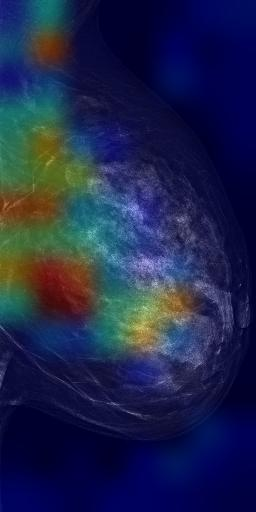

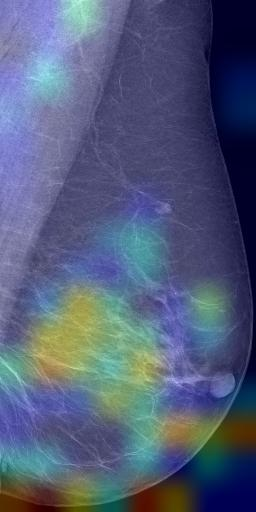

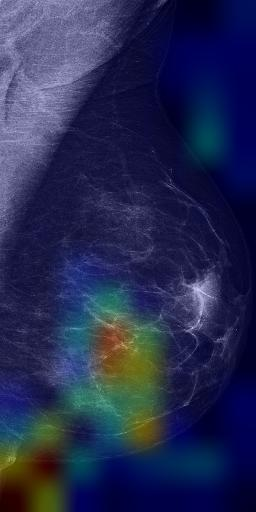

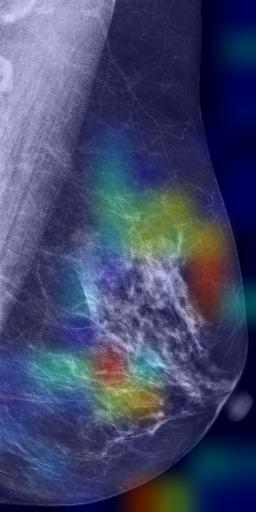

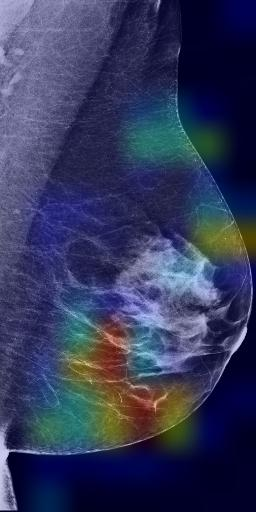

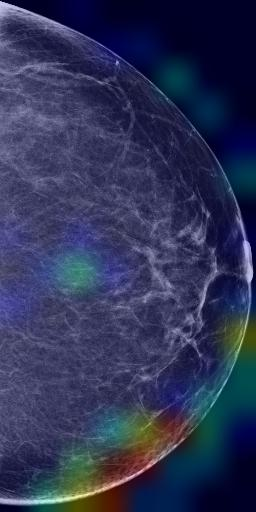

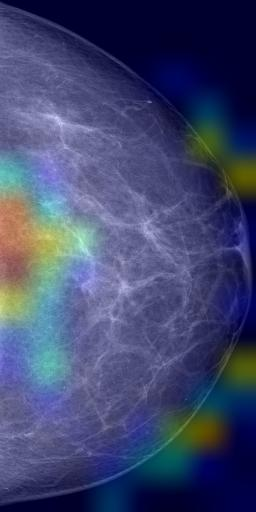

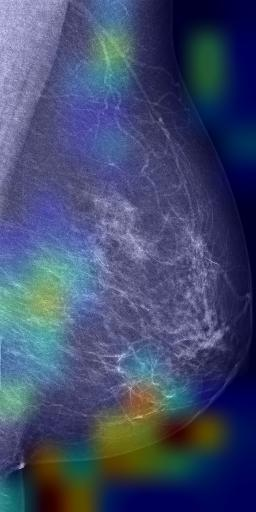

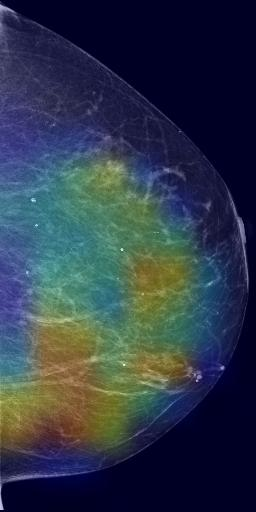

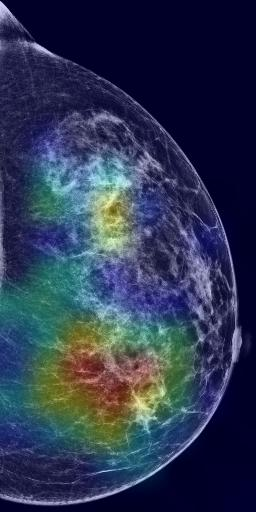

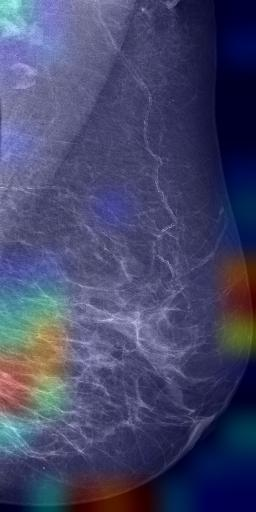

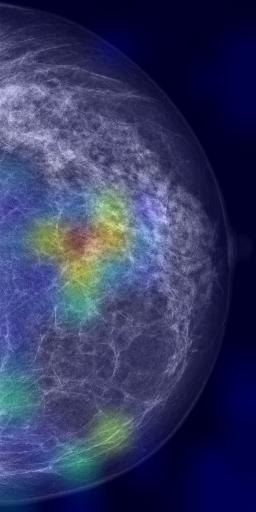

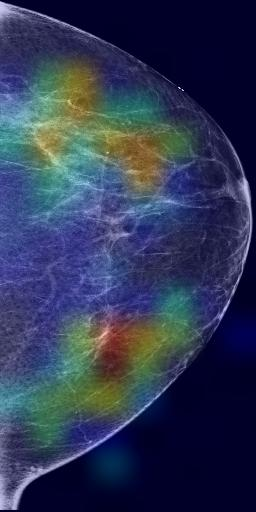

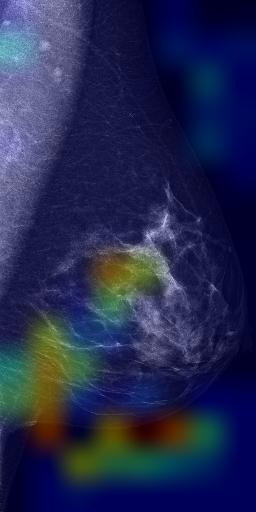

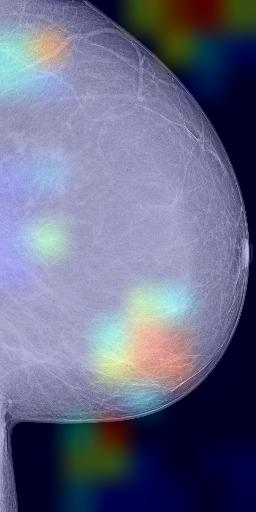

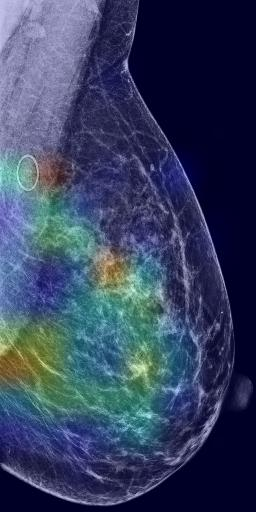

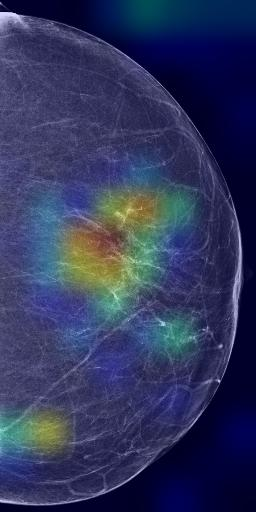

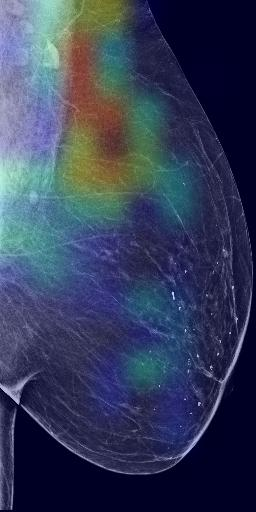

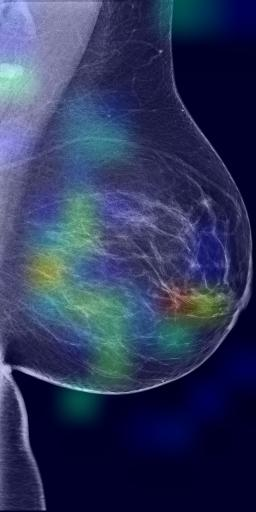

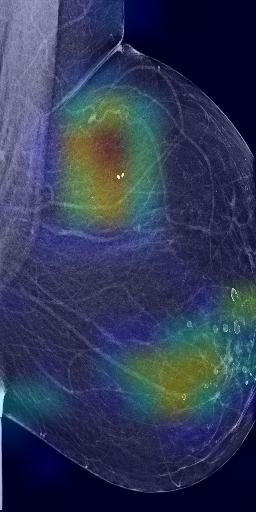

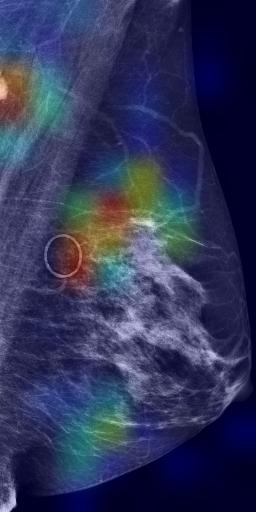

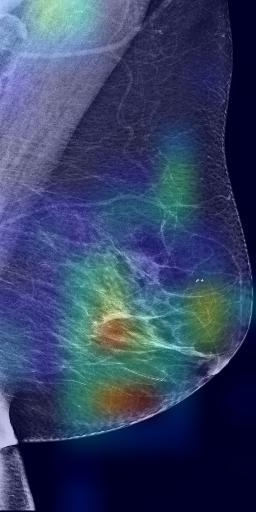

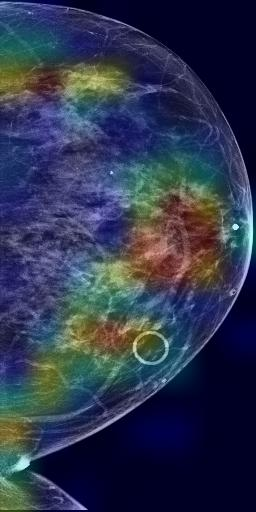

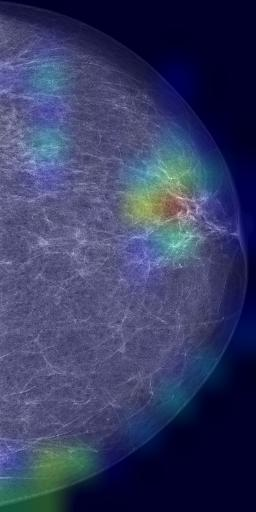

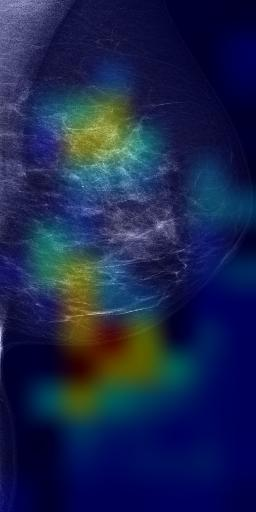

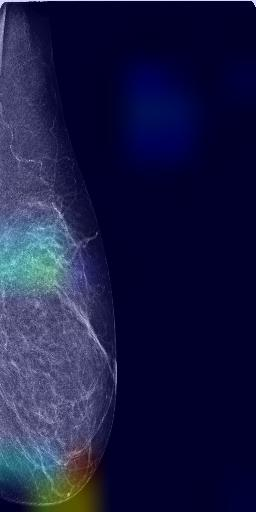

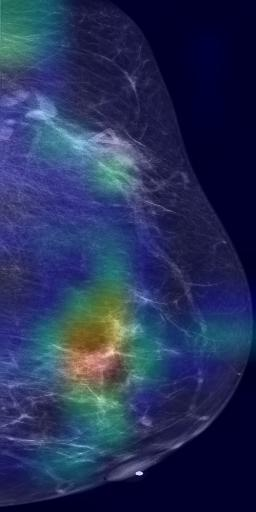

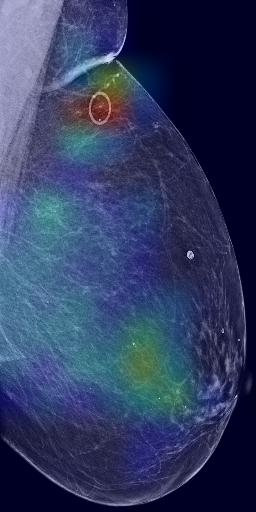

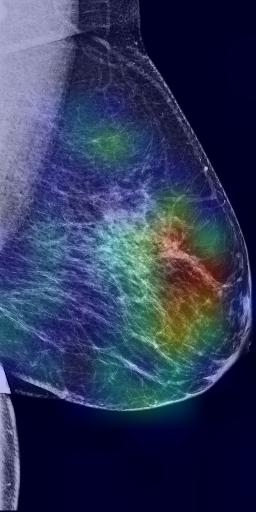

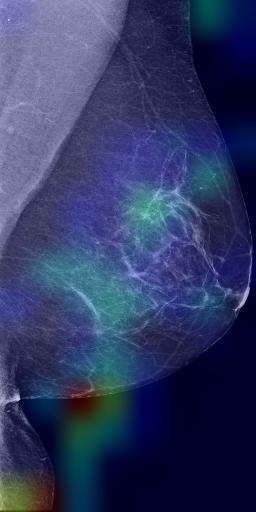

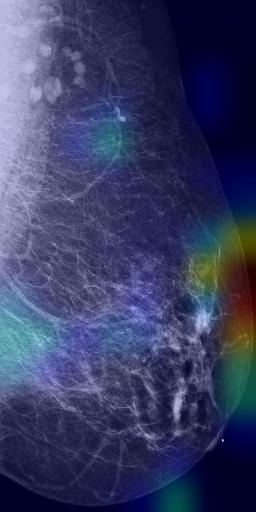

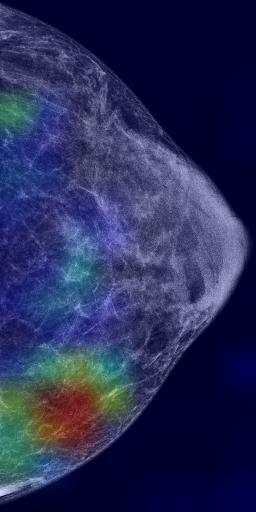

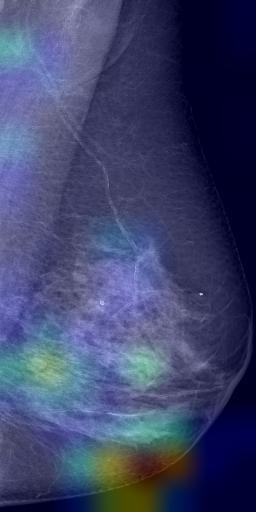

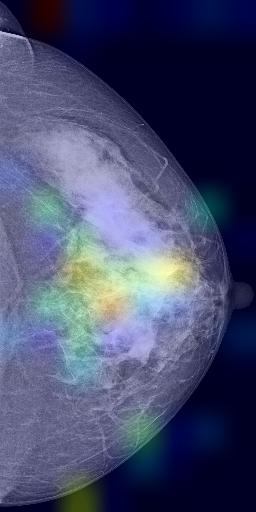

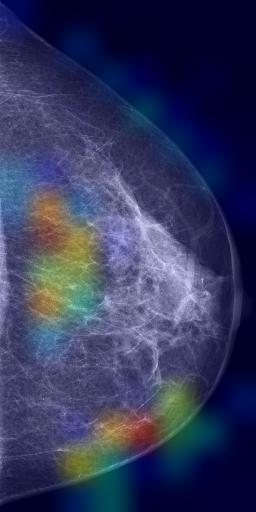

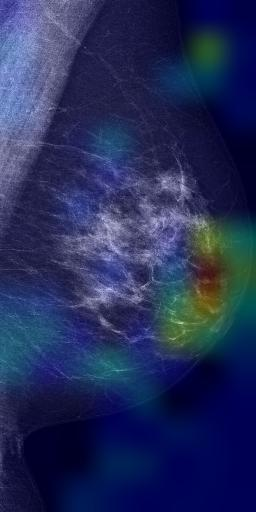

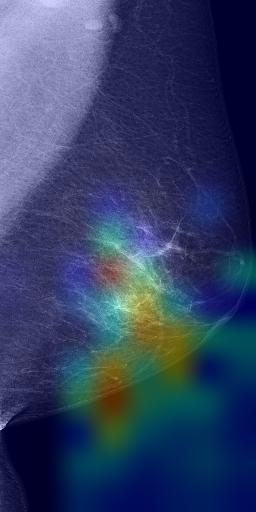

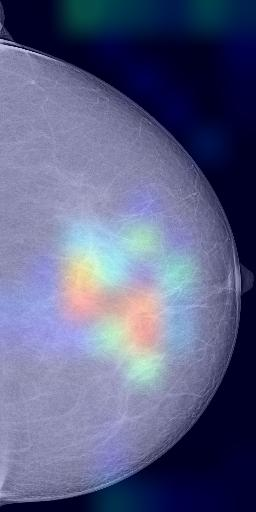

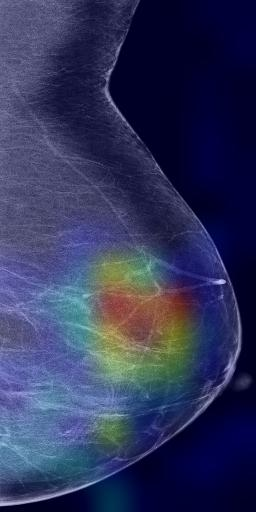

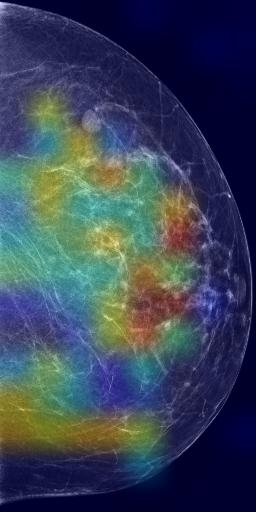

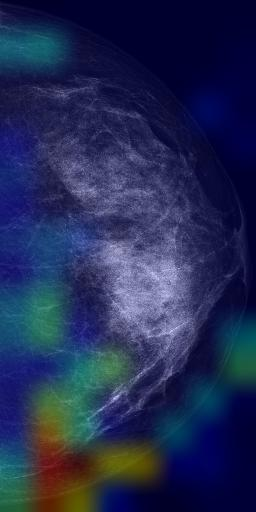

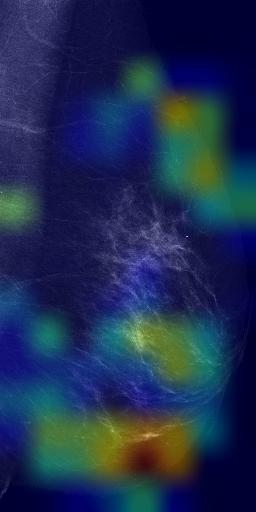

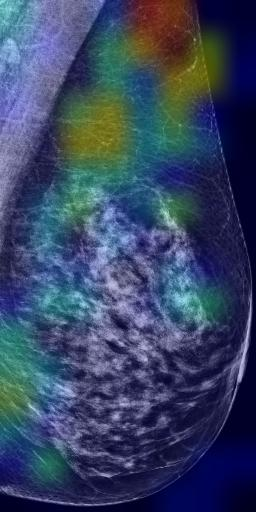

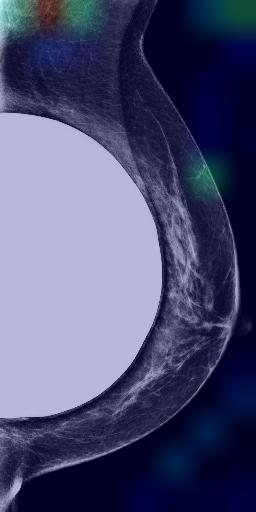

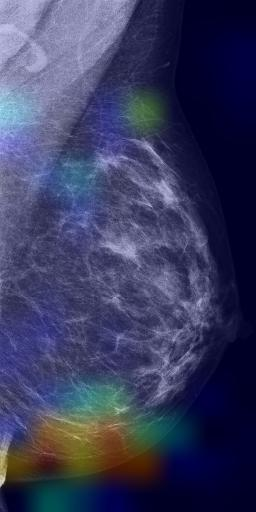

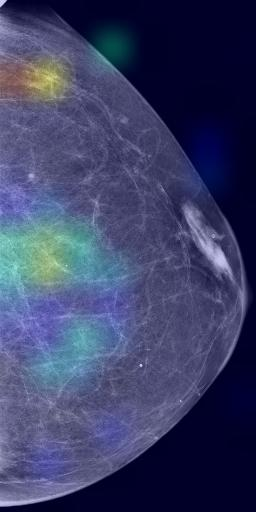

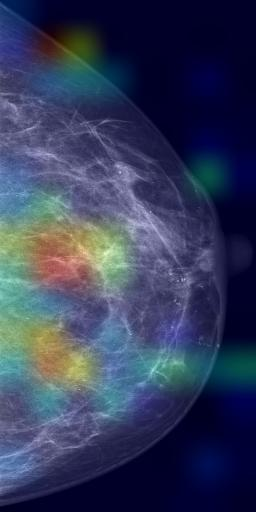

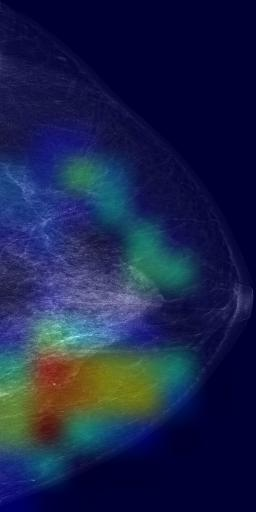

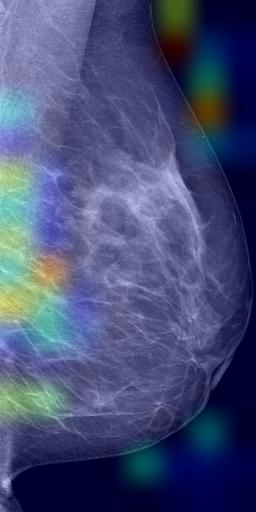

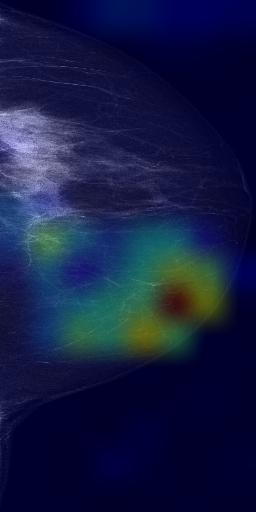

In [ ]:
img_size = (512, 256)
for img_path in benign_hit:
  img_array = preprocess_input(get_img_array(img_path, size=img_size))
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  save_and_display_gradcam(img_path, heatmap)

<ipython-input-16-66be92efd339>:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


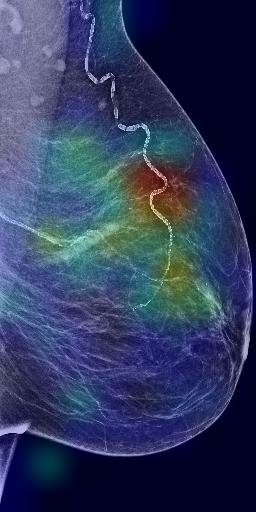

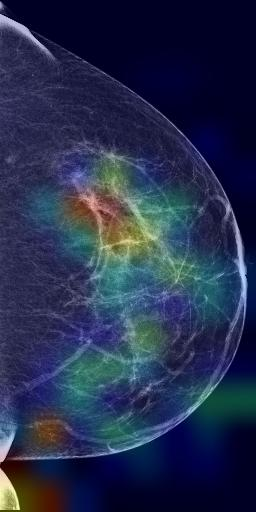

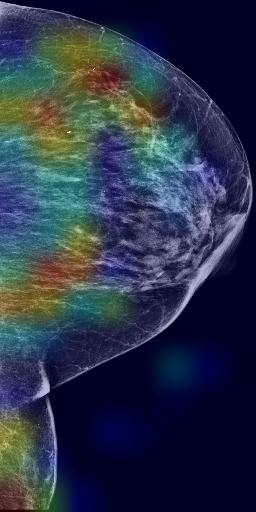

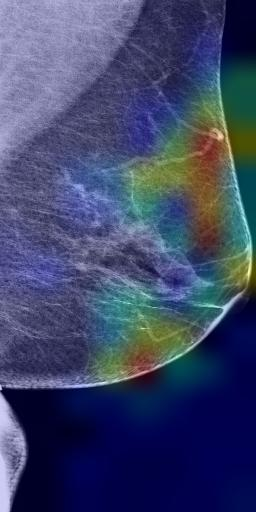

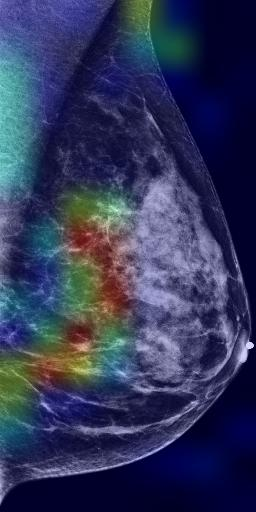

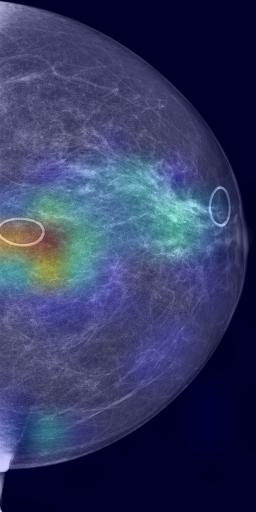

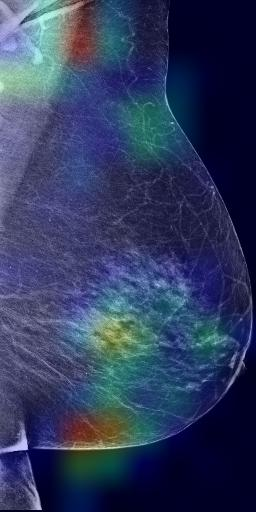

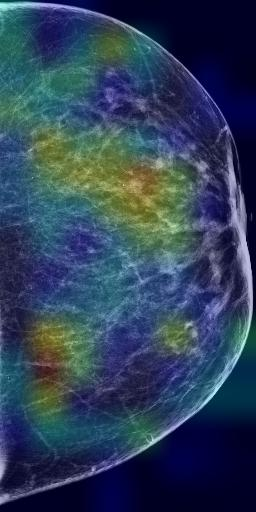

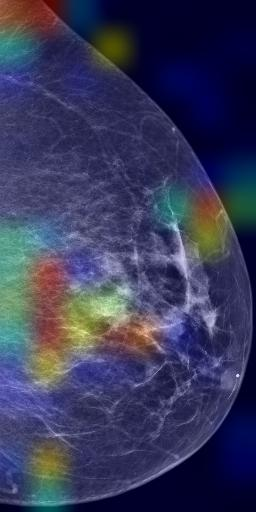

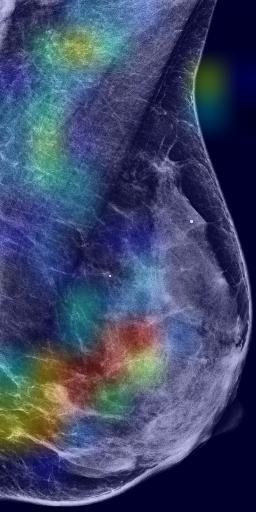

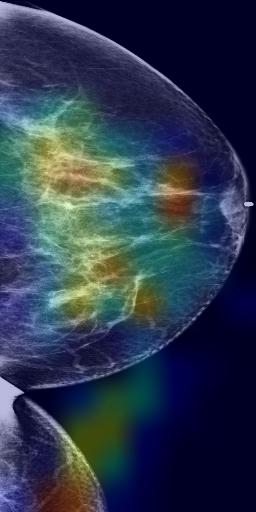

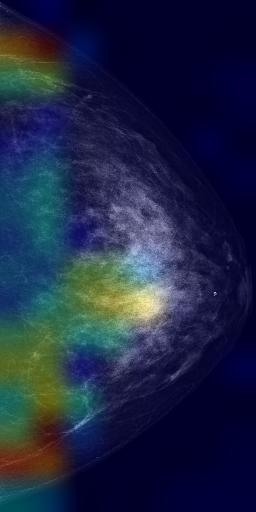

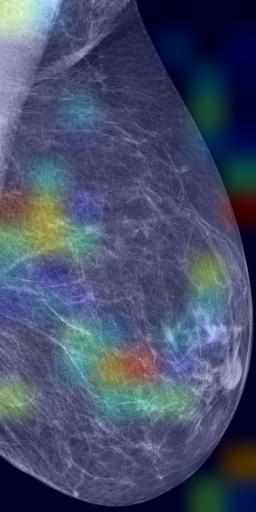

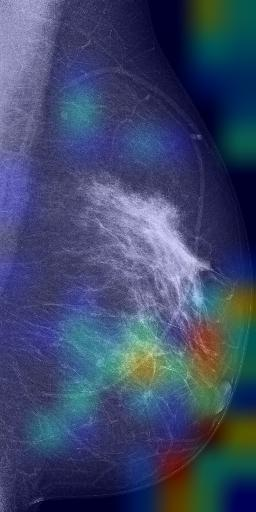

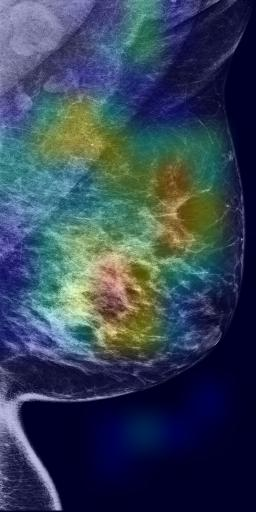

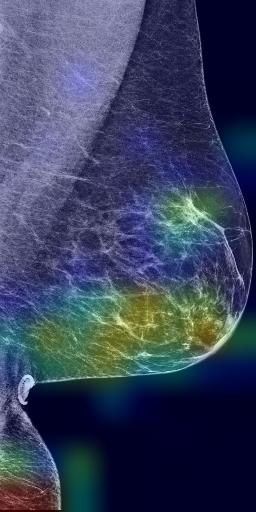

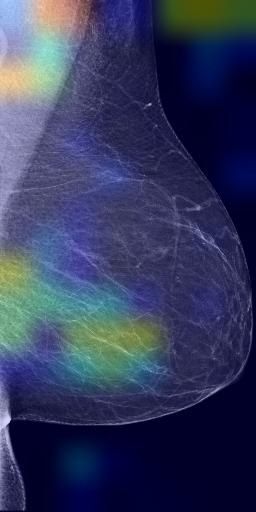

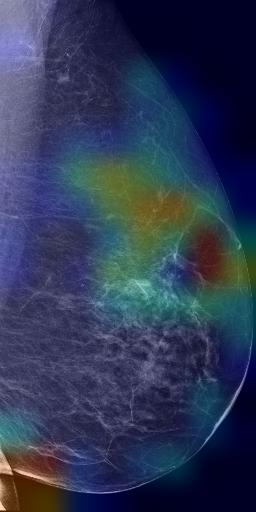

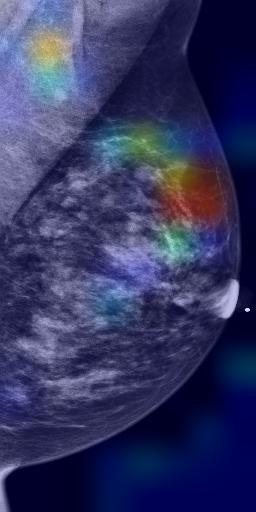

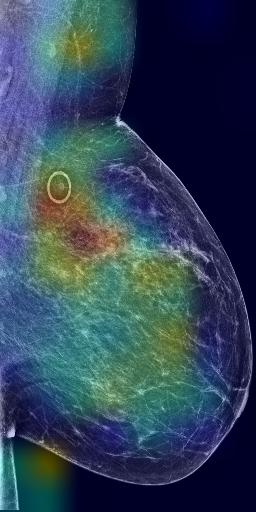

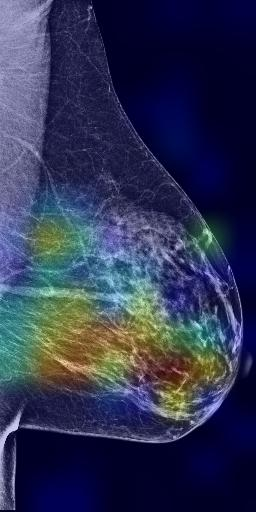

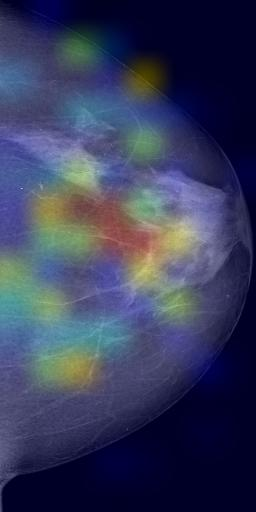

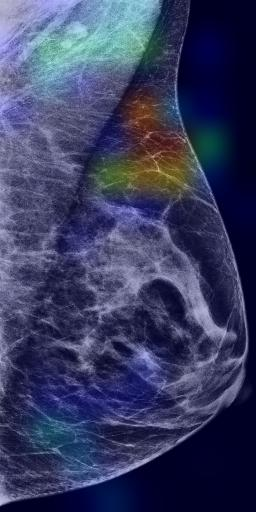

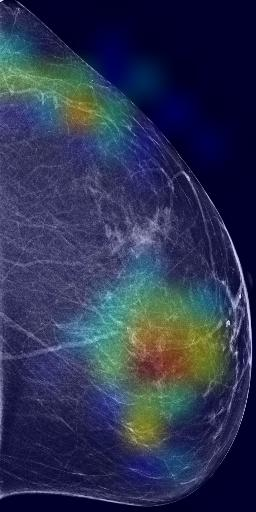

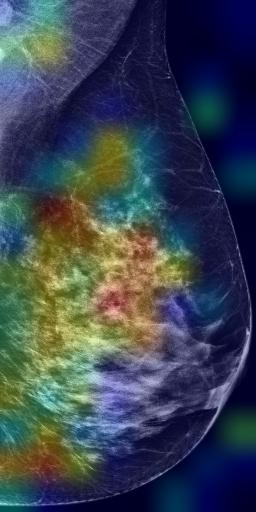

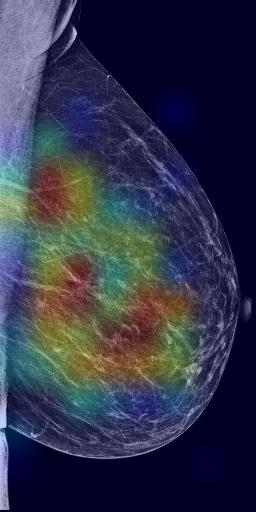

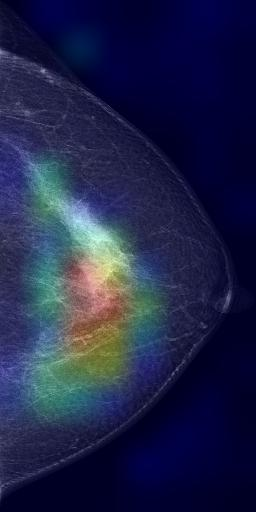

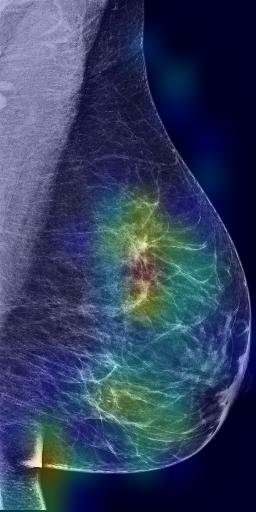

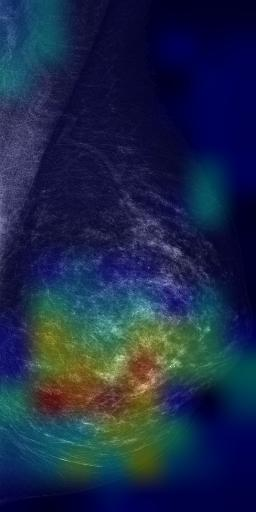

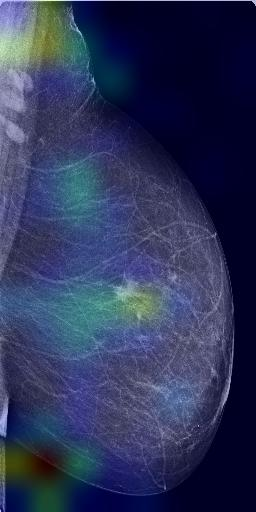

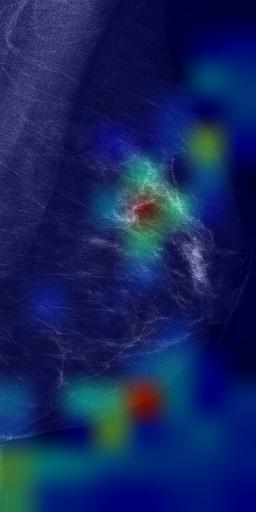

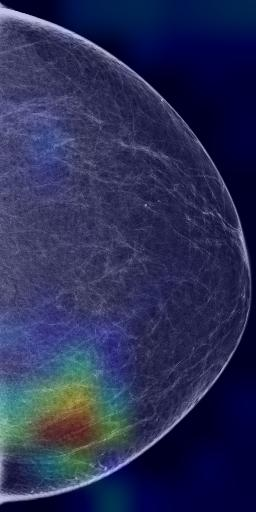

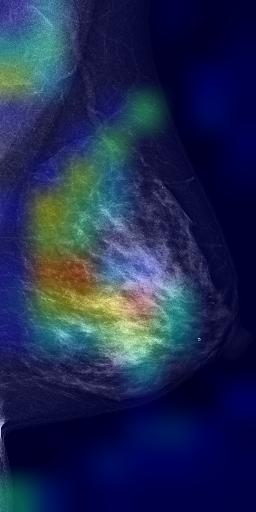

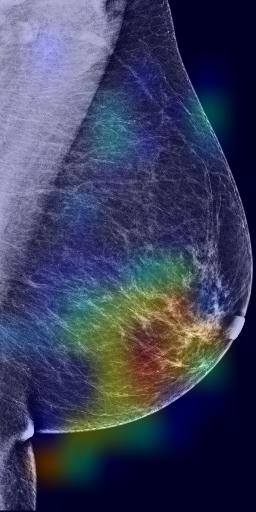

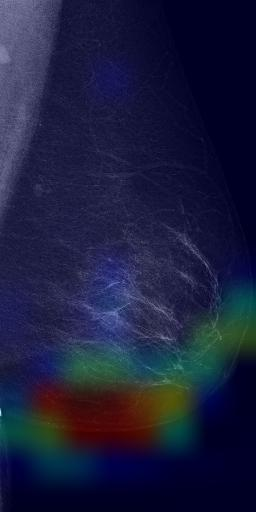

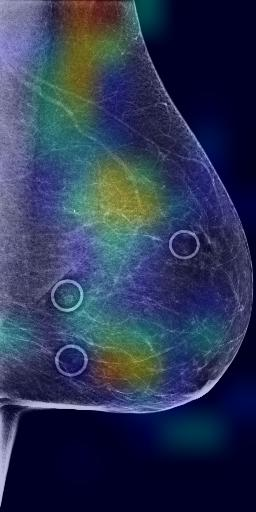

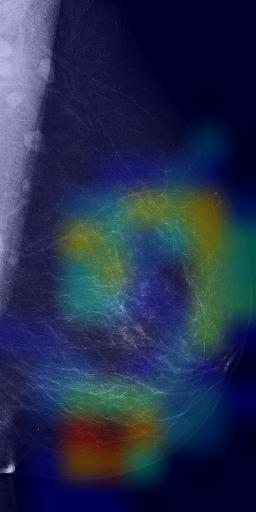

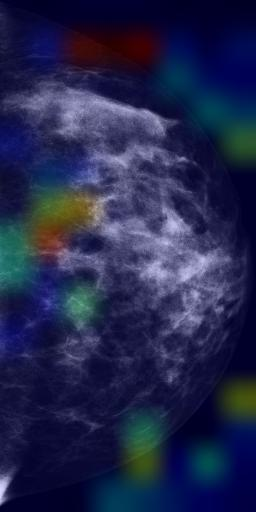

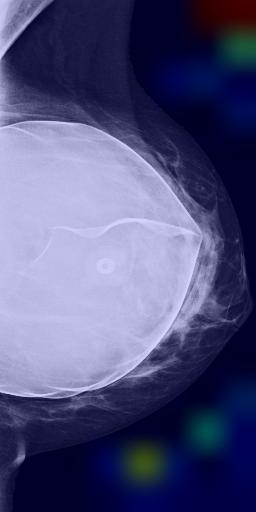

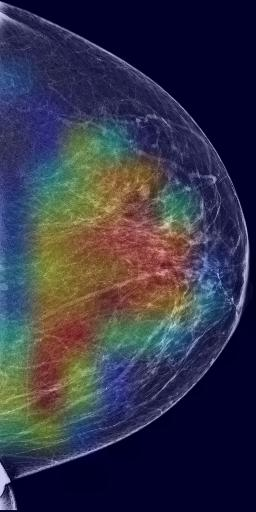

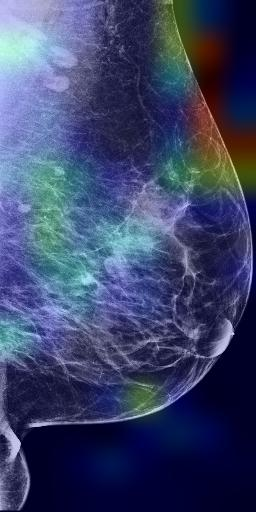

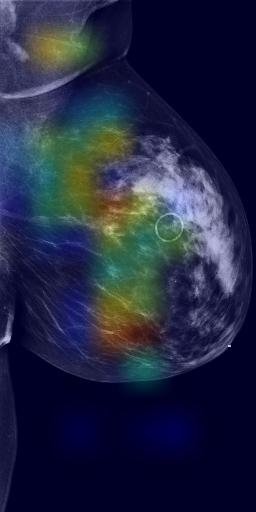

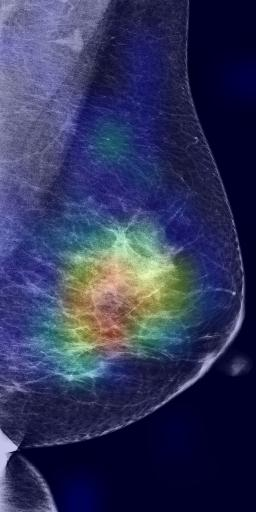

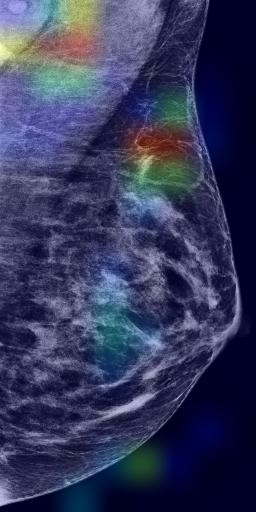

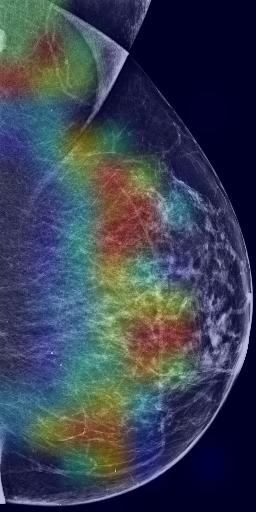

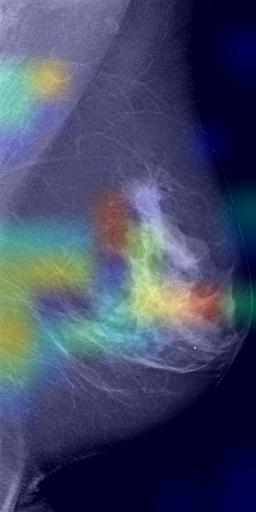

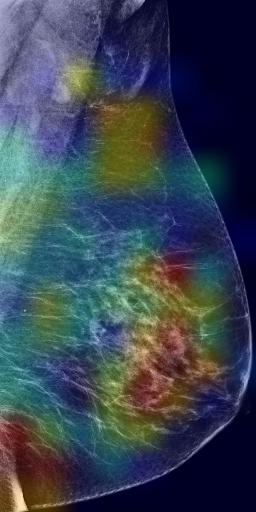

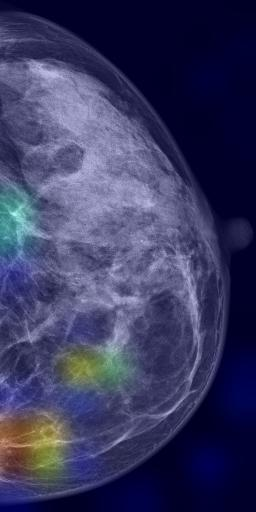

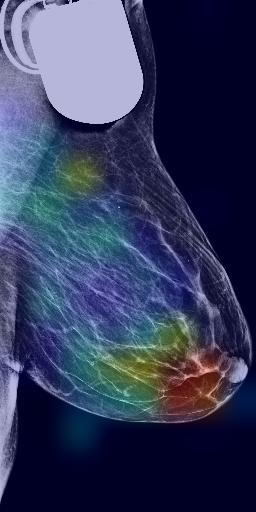

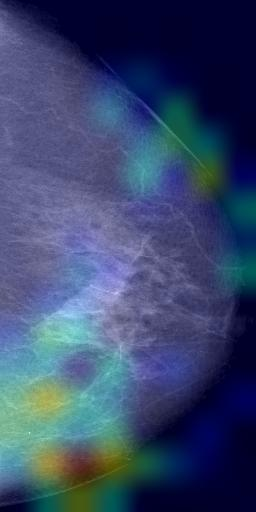

In [ ]:
img_size = (512, 256)
for img_path in benign_miss:
  img_array = preprocess_input(get_img_array(img_path, size=img_size))
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  save_and_display_gradcam(img_path, heatmap)

<ipython-input-16-66be92efd339>:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


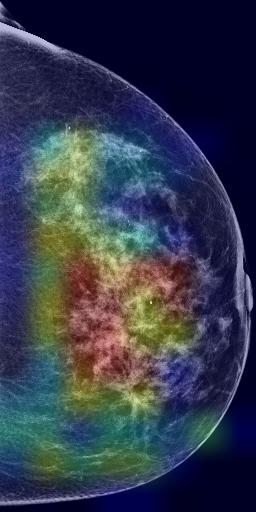

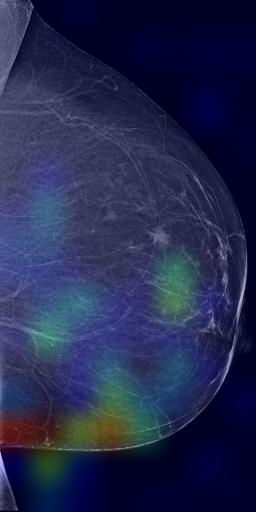

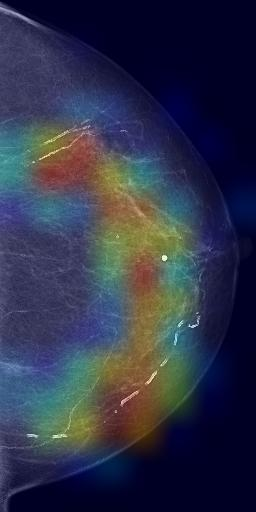

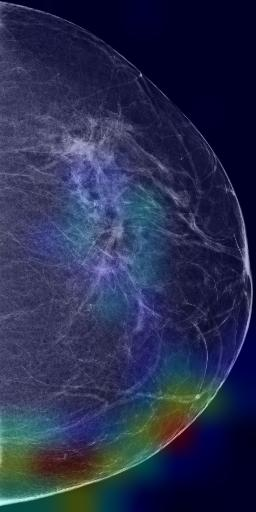

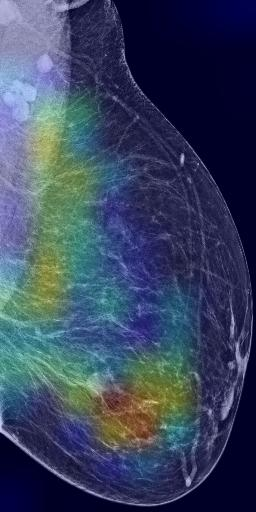

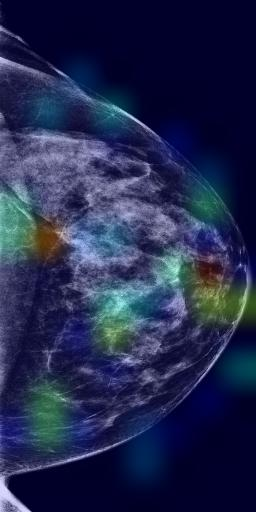

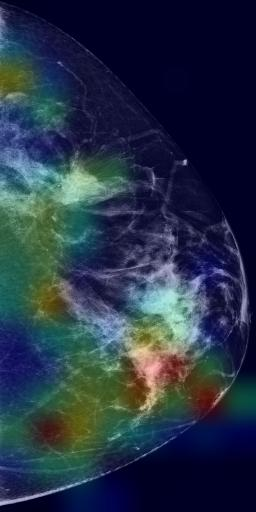

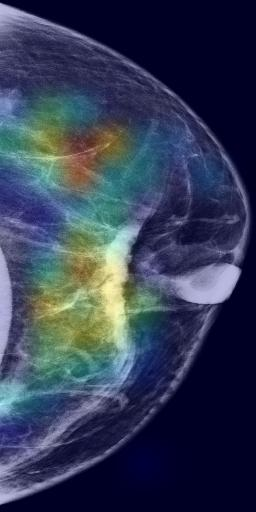

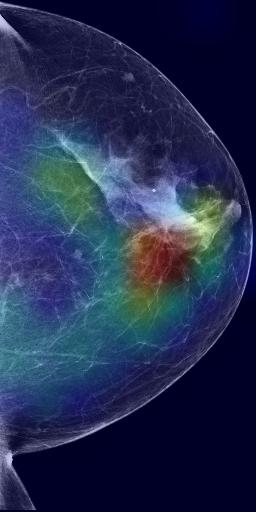

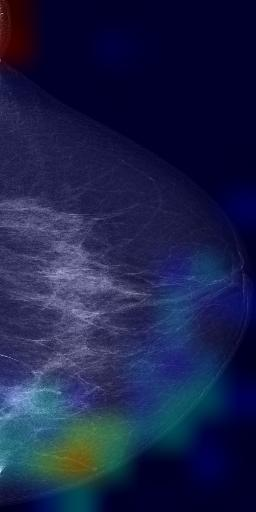

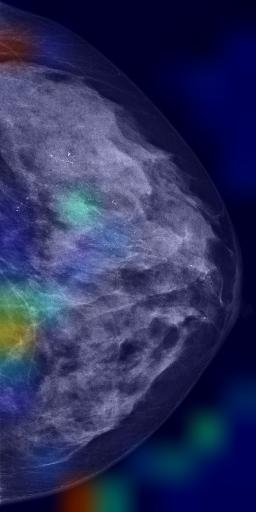

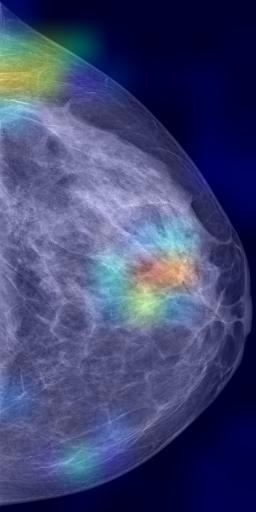

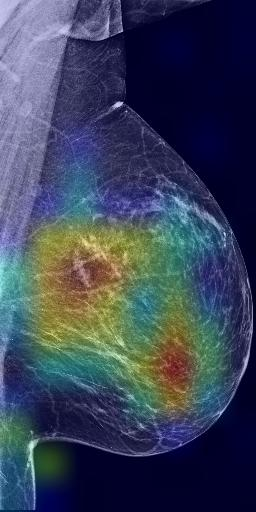

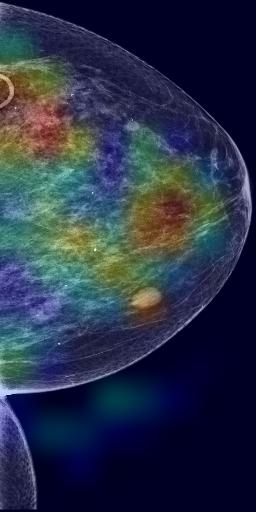

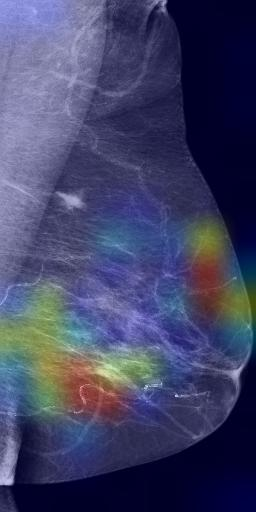

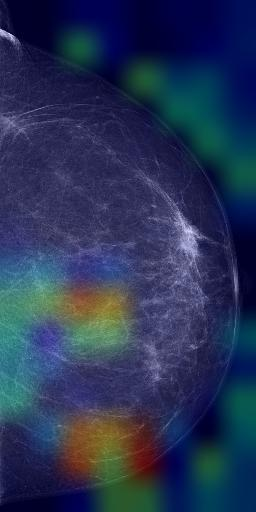

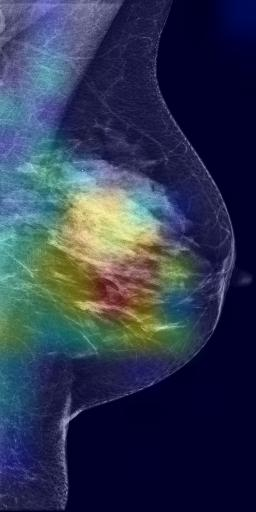

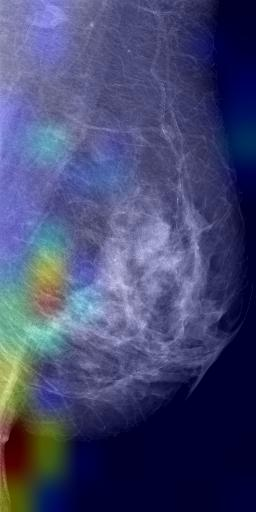

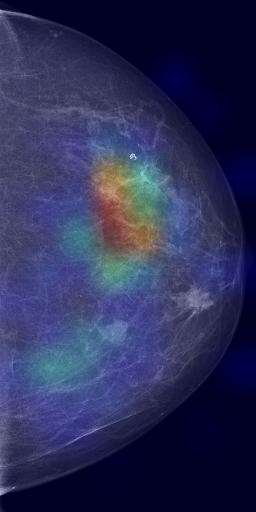

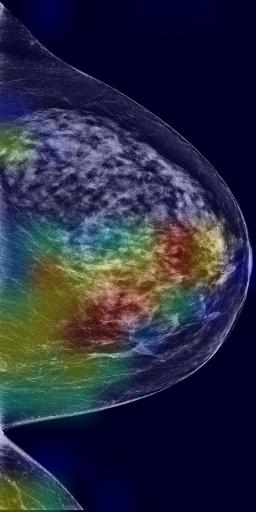

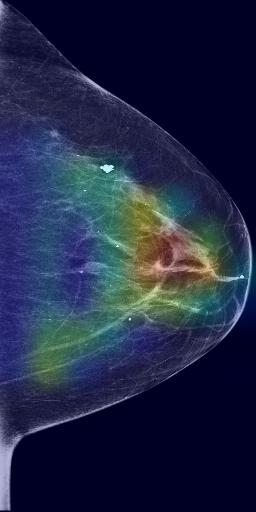

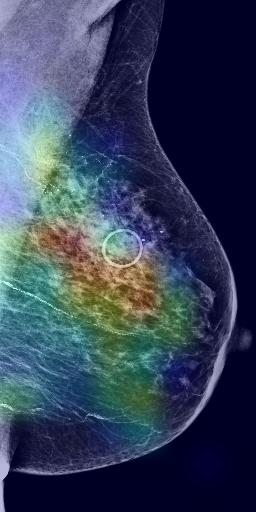

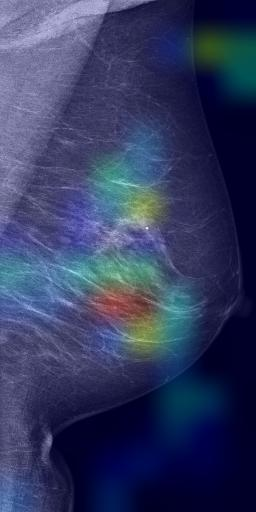

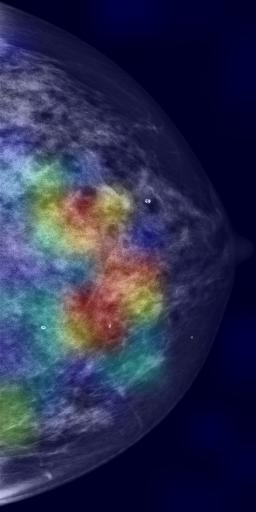

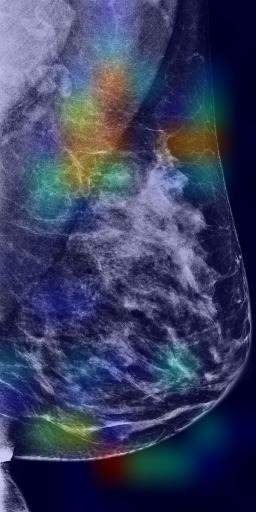

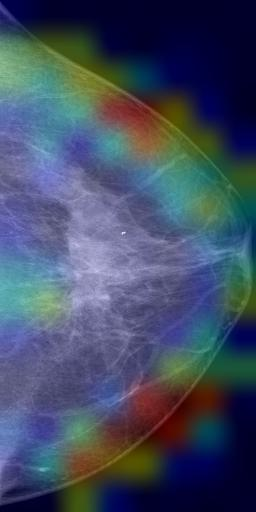

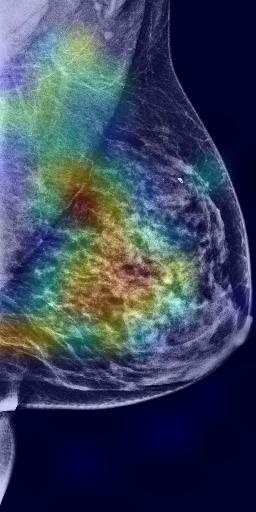

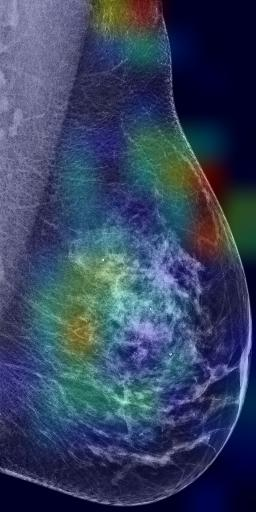

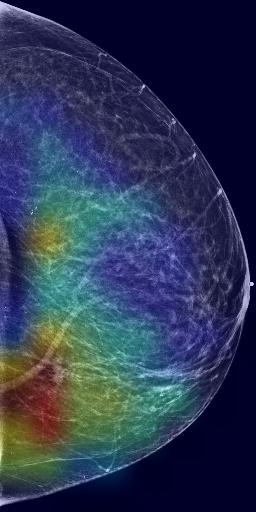

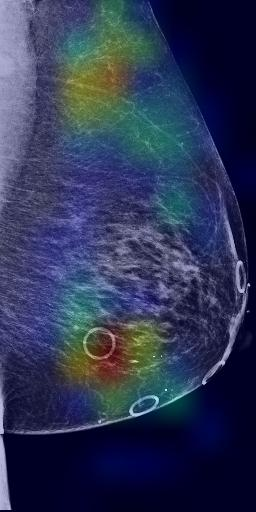

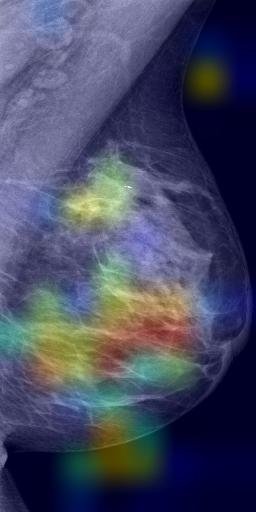

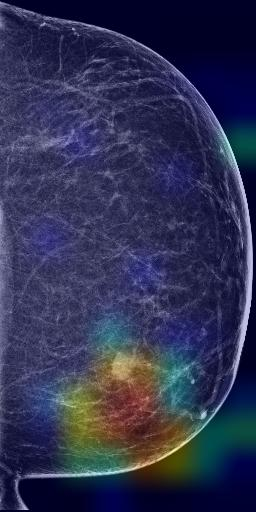

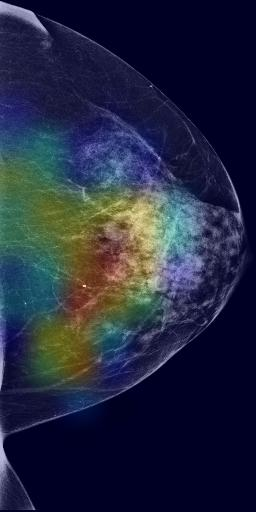

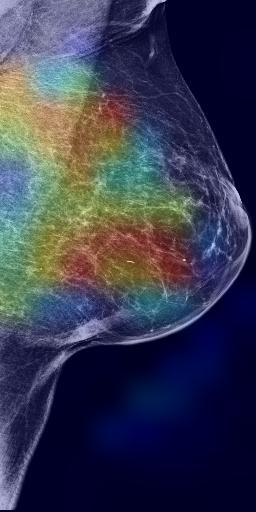

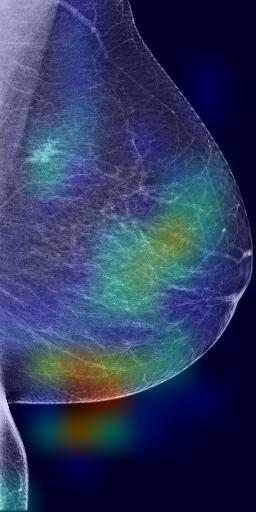

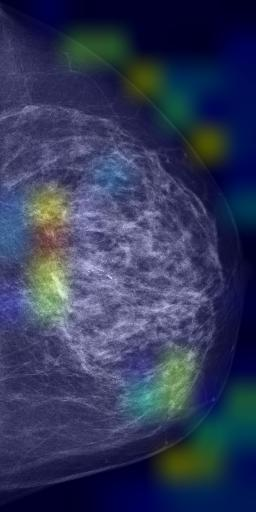

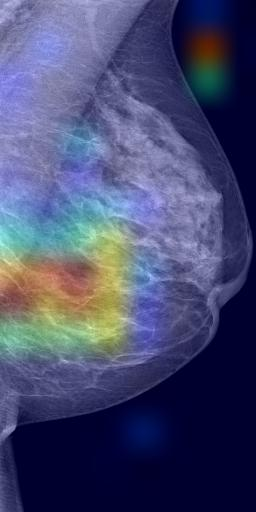

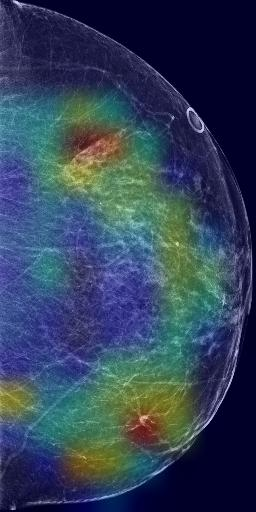

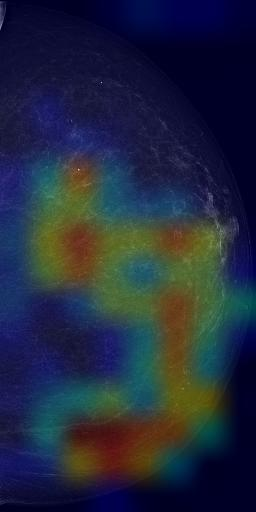

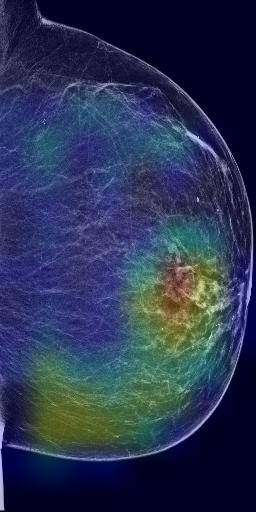

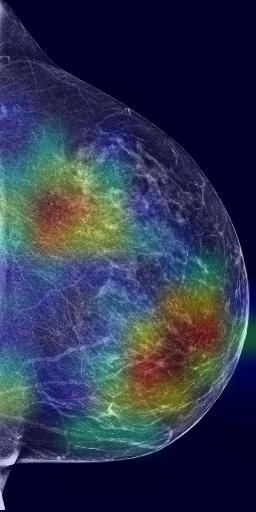

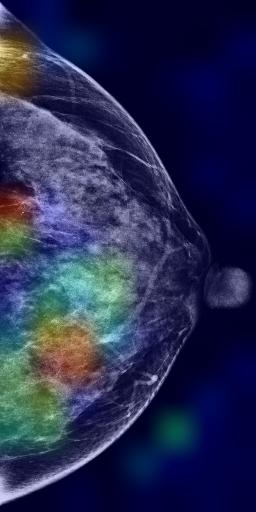

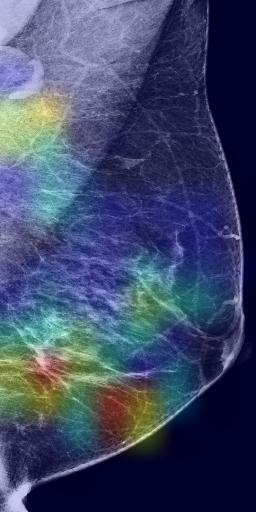

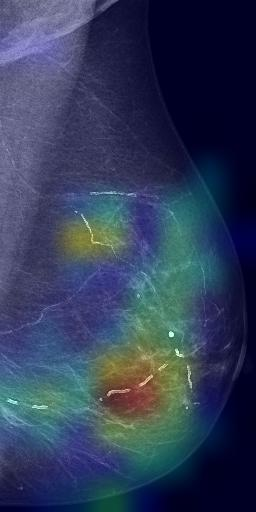

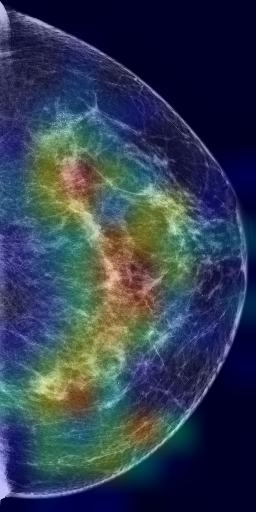

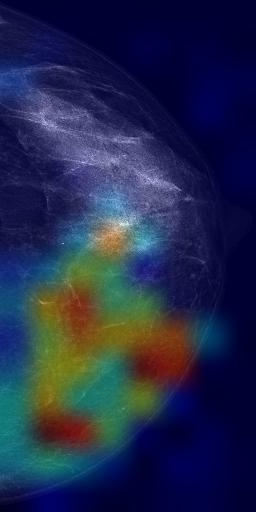

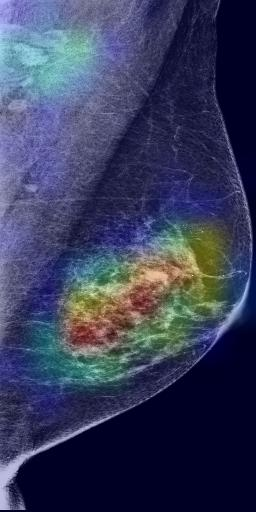

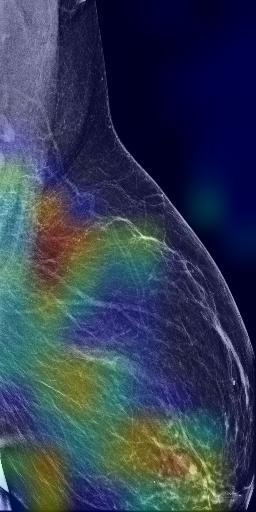

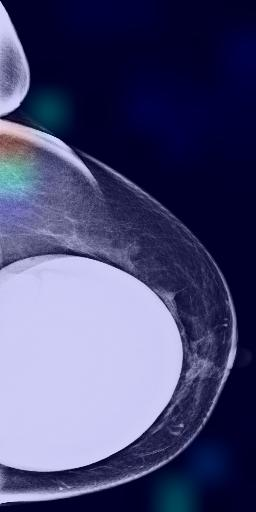

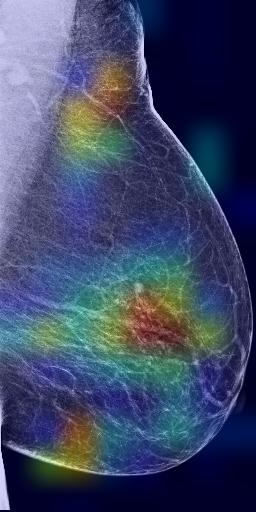

In [ ]:
img_size = (512, 256)
for img_path in malicious_hit:
  img_array = preprocess_input(get_img_array(img_path, size=img_size))
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  save_and_display_gradcam(img_path, heatmap)

<ipython-input-16-66be92efd339>:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


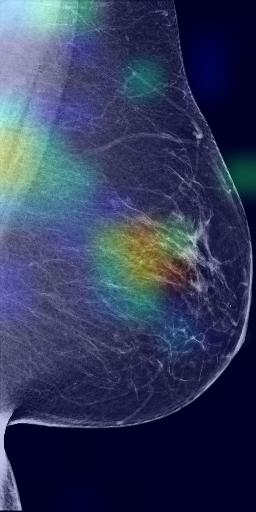

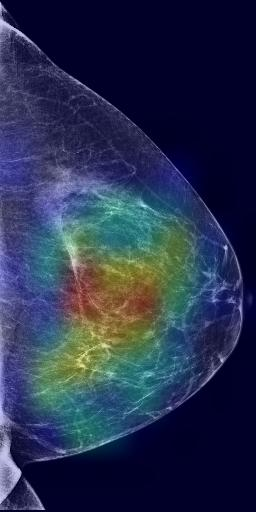

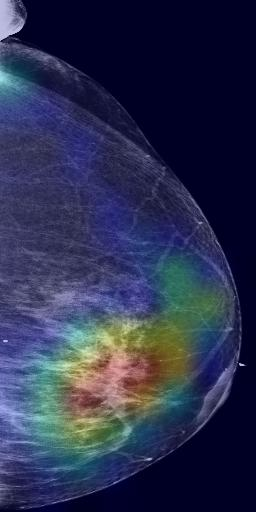

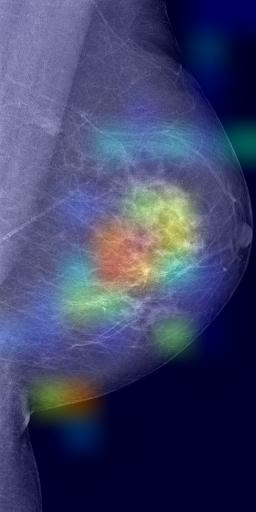

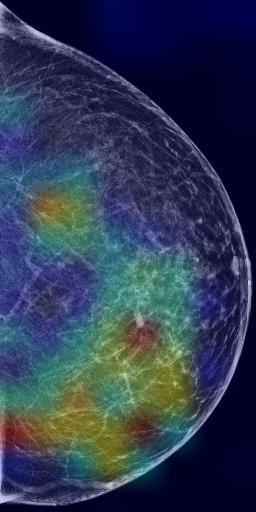

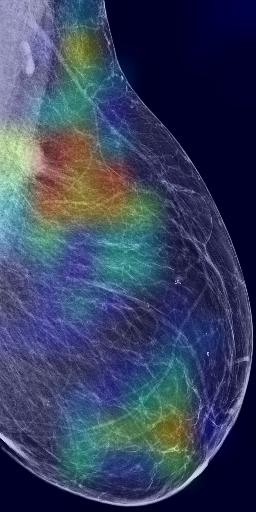

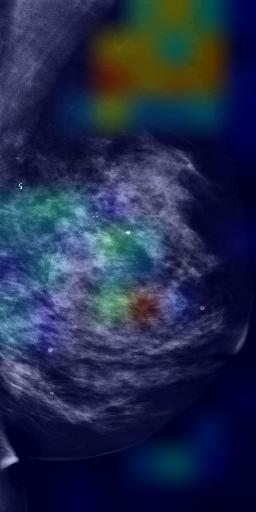

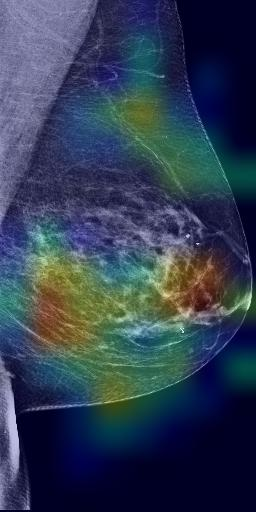

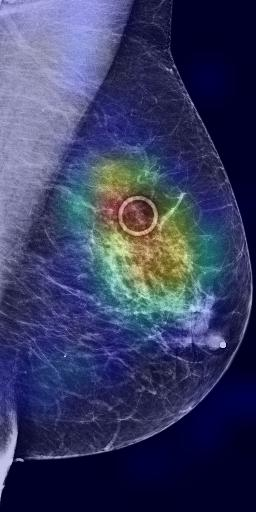

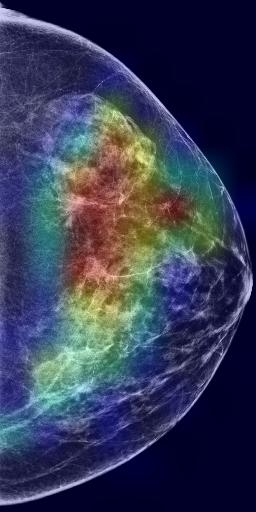

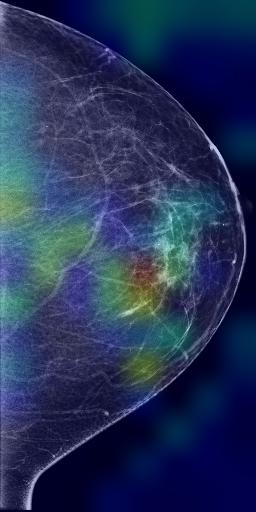

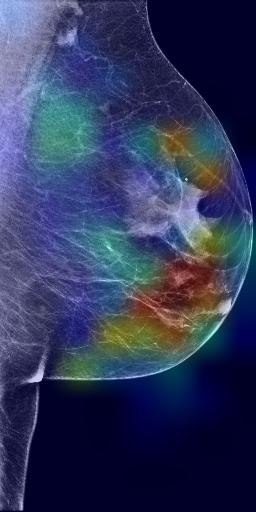

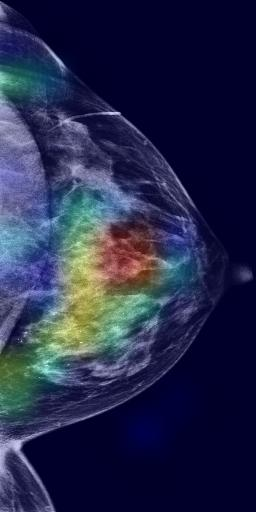

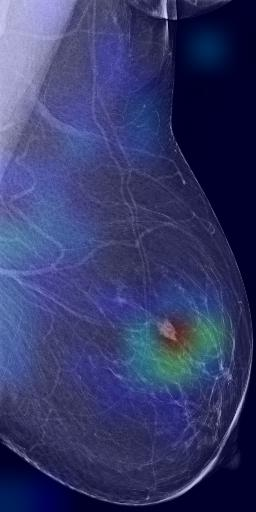

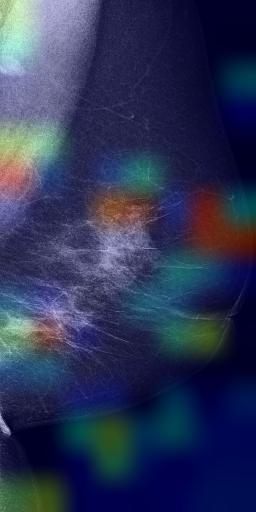

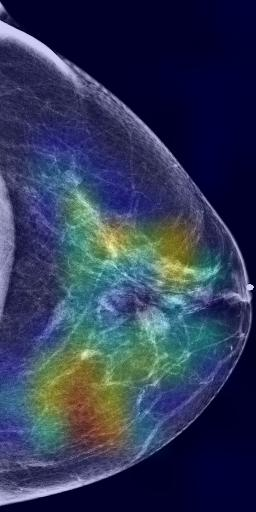

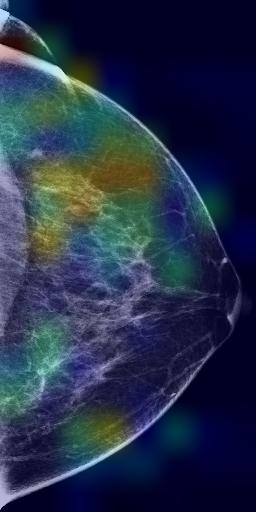

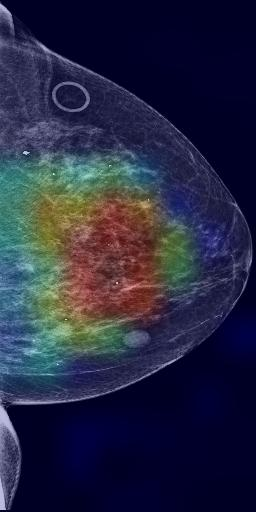

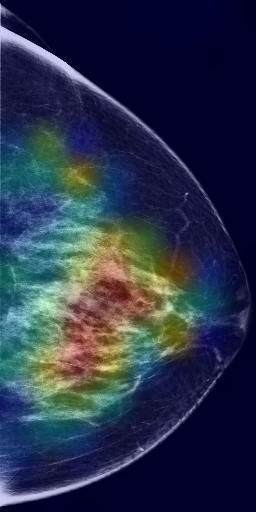

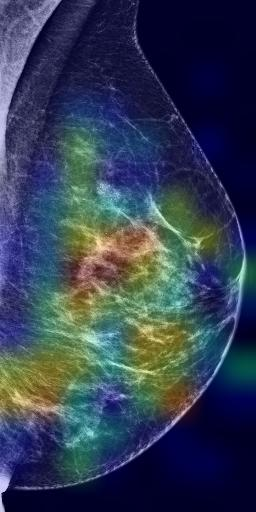

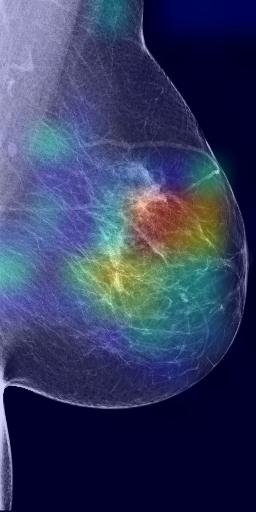

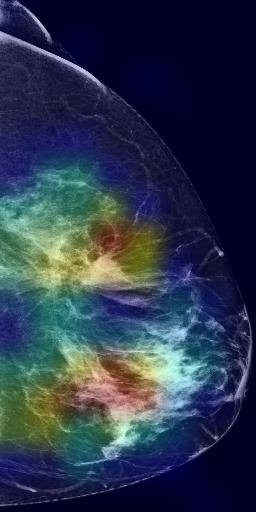

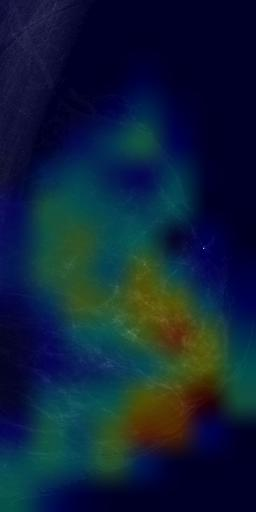

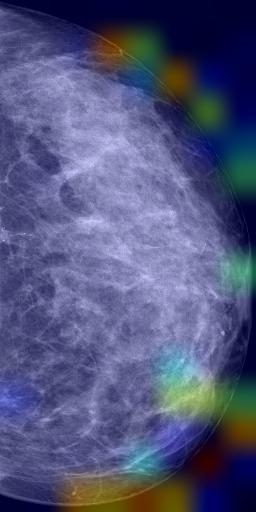

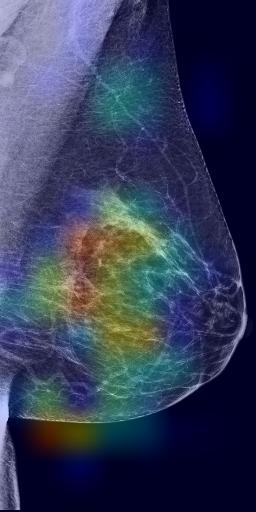

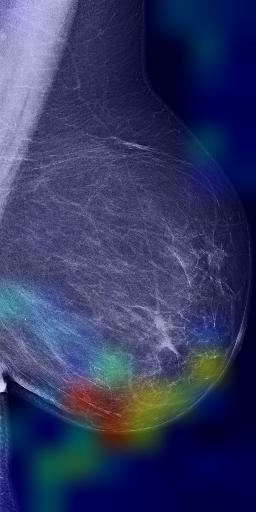

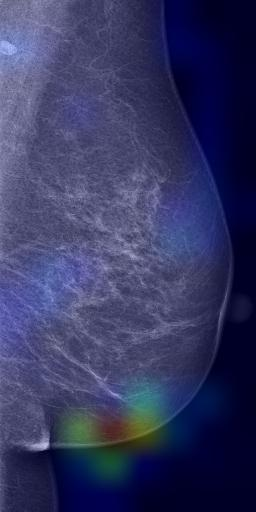

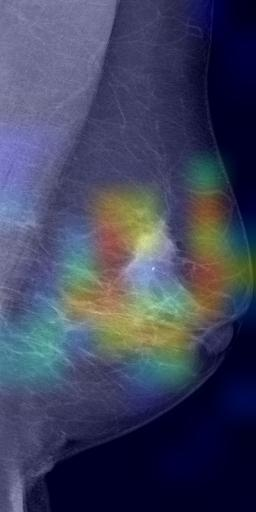

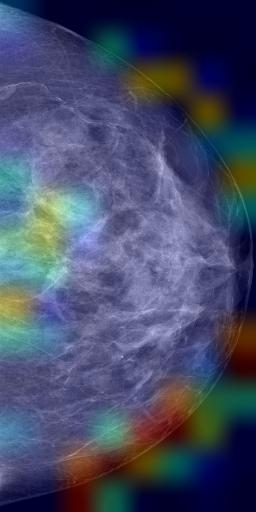

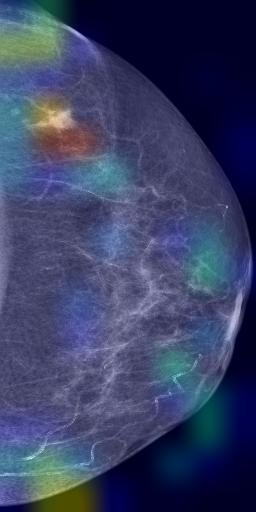

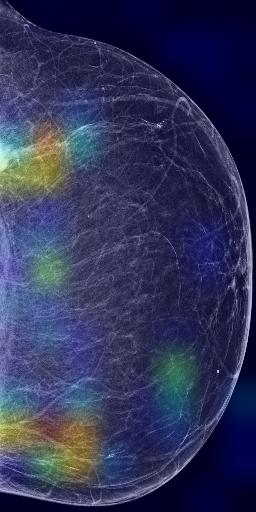

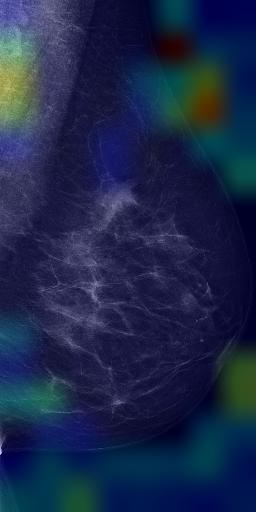

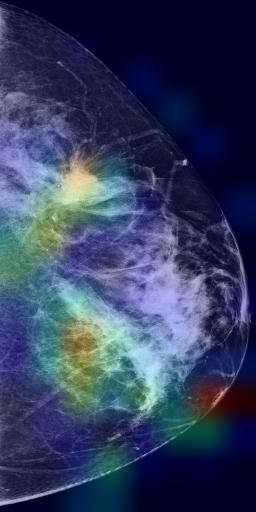

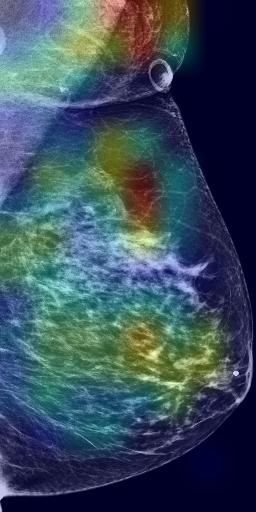

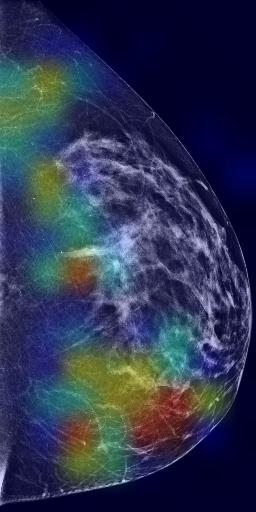

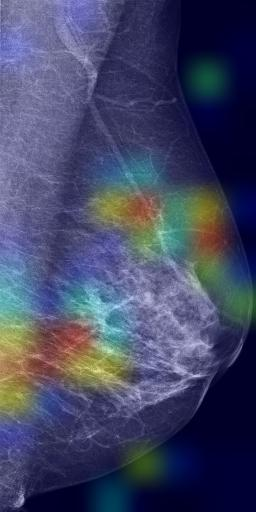

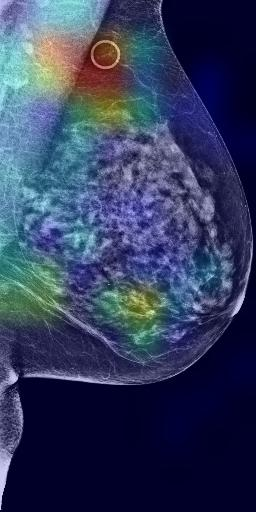

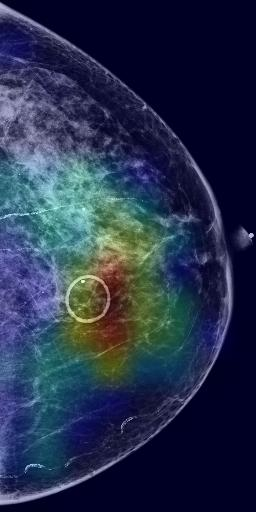

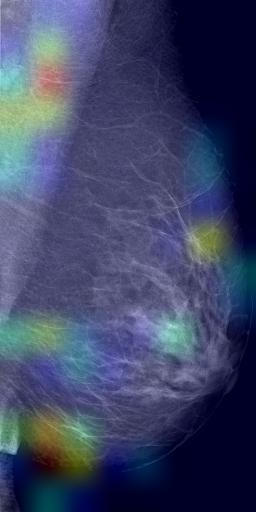

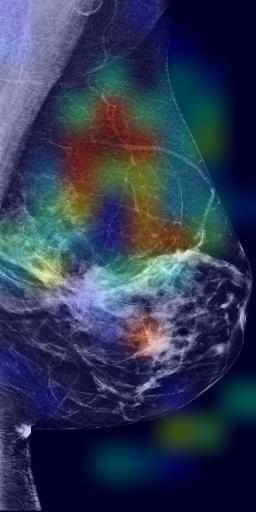

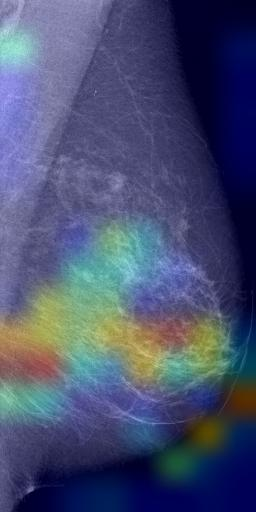

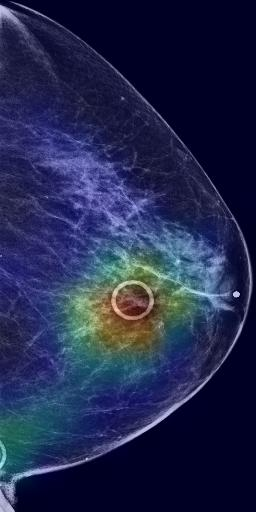

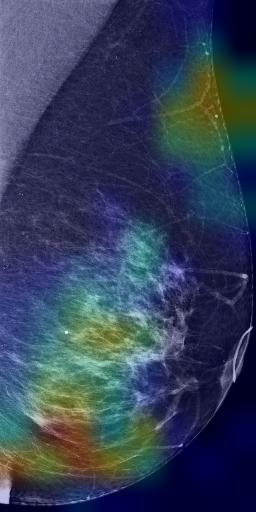

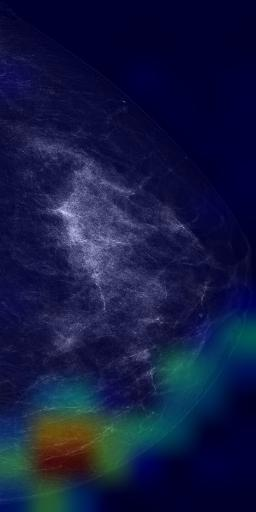

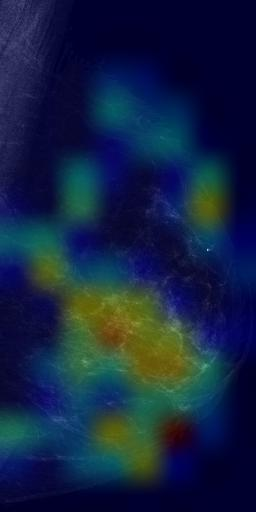

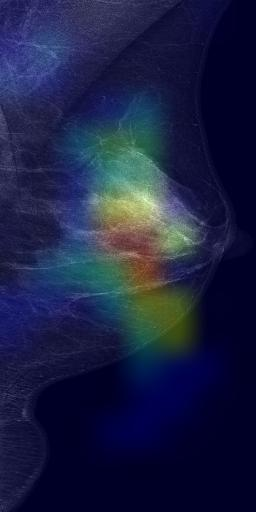

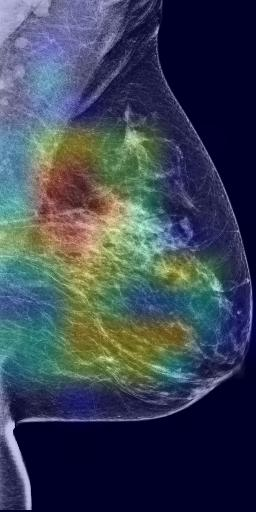

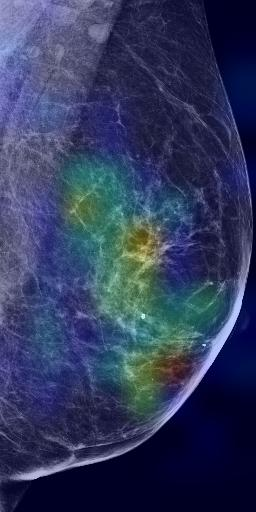

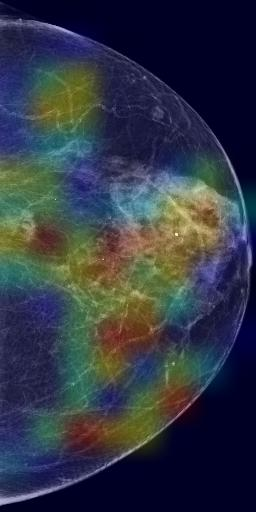

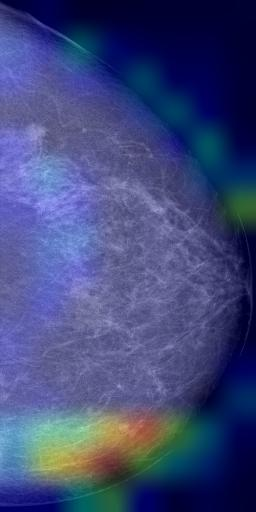

In [ ]:
img_size = (512, 256)
for img_path in malicious_miss:
  img_array = preprocess_input(get_img_array(img_path, size=img_size))
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  save_and_display_gradcam(img_path, heatmap)